In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
code = {'Tomato___Bacterial_spot':0 ,'Tomato___Early_blight':1,'Tomato___Late_blight':2,'Tomato___Leaf_Mold':3,'Tomato___Septoria_leaf_spot':4,'Tomato___Spider_mites Two-spotted_spider_mite':5 , 'Tomato___Target_Spot':6 ,'Tomato___Tomato_Yellow_Leaf_Curl_Virus':7 , 'Tomato___Tomato_mosaic_virus':8 ,'Tomato___healthy':9  }

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [26]:
path='/kaggle/input/plantvillage-dataset/color/'

In [27]:
s = 128
X = []
y = []
for folder in  os.listdir(path) :
    if(folder.startswith("Tomato")):
        files = gb.glob(pathname= str( path  + folder + '/*.JPG'))
        print(folder)
        for file in files: 
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            image=image/255
            X.append(list(image_array))
            y.append(folder)

print(f'we have {len(X)} items in X ')

Tomato___Late_blight
Tomato___healthy
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
we have 18006 items in X 


In [28]:
y = np.array(y).reshape(-1, 1)

In [29]:
from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder()
y=one.fit_transform(y).toarray()

In [30]:
X = np.array(X)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=True, random_state=42)

In [32]:
del X
del y

In [33]:
from sklearn.model_selection import train_test_split
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5,  shuffle=True, random_state=42)

In [34]:
class Config(object):
    input_shape = (128, 128, 3)
    num_classes = 10


    # ARCHITECTURE
    patch_size = 4
    projected_dim = 48
    num_shift_blocks_per_stages = [2, 4, 8, 2]
    epsilon = 1e-5
    stochastic_depth_rate = 0.2
    mlp_dropout_rate = 0.2
    num_div = 3
    shift_pixel = 1
    mlp_expand_ratio = 2



    # TRAINING
    epochs = 50


config = Config()

In [35]:
class MLP(layers.Layer):
    """Get the MLP layer for each shift block.

    Args:
        mlp_expand_ratio (int): The ratio with which the first feature map is expanded.
        mlp_dropout_rate (float): The rate for dropout.
    """

    def __init__(self, mlp_expand_ratio, mlp_dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.mlp_expand_ratio = mlp_expand_ratio
        self.mlp_dropout_rate = mlp_dropout_rate

    def build(self, input_shape):
        input_channels = input_shape[-1]
        initial_filters = int(self.mlp_expand_ratio * input_channels)

        self.mlp = keras.Sequential(
            [
                layers.Dense(units=initial_filters, activation=tf.nn.gelu,),
                layers.Dropout(rate=self.mlp_dropout_rate),
                layers.Dense(units=input_channels),
                layers.Dropout(rate=self.mlp_dropout_rate),
            ]
        )

    def call(self, x):
        x = self.mlp(x)
        return x


In [14]:
class DropPath(layers.Layer):
    """Drop Path also known as the Stochastic Depth layer.

    Refernece:
        - https://keras.io/examples/vision/cct/#stochastic-depth-for-regularization
        - github.com:rwightman/pytorch-image-models
    """

    def __init__(self, drop_path_prob, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_prob = drop_path_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_path_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [36]:

class ShiftViTBlock(layers.Layer):
    """A unit ShiftViT Block

    Args:
        shift_pixel (int): The number of pixels to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which MLP features are
            expanded. Default to 2.
        mlp_dropout_rate (float): The dropout rate used in MLP.
        num_div (int): The number of divisions of the feature map's channel.
            Totally, 4/num_div of channels will be shifted. Defaults to 12.
        epsilon (float): Epsilon constant.
        drop_path_prob (float): The drop probability for drop path.
    """

    def __init__(
        self,
        epsilon,
        drop_path_prob,
        mlp_dropout_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.shift_pixel = shift_pixel
        self.mlp_expand_ratio = mlp_expand_ratio
        self.mlp_dropout_rate = mlp_dropout_rate
        self.num_div = num_div
        self.epsilon = epsilon
        self.drop_path_prob = drop_path_prob

    def build(self, input_shape):
        self.H = input_shape[1]
        self.W = input_shape[2]
        self.C = input_shape[3]
        self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)
        self.drop_path = (
            DropPath(drop_path_prob=self.drop_path_prob)
            if self.drop_path_prob > 0.0
            else layers.Activation("linear")
        )
        self.mlp = MLP(
            mlp_expand_ratio=self.mlp_expand_ratio,
            mlp_dropout_rate=self.mlp_dropout_rate,
        )

    def get_shift_pad(self, x, mode):
        """Shifts the channels according to the mode chosen."""
        if mode == "left":
            offset_height = 0
            offset_width = 0
            target_height = 0
            target_width = self.shift_pixel
        elif mode == "right":
            offset_height = 0
            offset_width = self.shift_pixel
            target_height = 0
            target_width = self.shift_pixel
        elif mode == "up":
            offset_height = 0
            offset_width = 0
            target_height = self.shift_pixel
            target_width = 0
        else:
            offset_height = self.shift_pixel
            offset_width = 0
            target_height = self.shift_pixel
            target_width = 0
        crop = tf.image.crop_to_bounding_box(
            x,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H - target_height,
            target_width=self.W - target_width,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H,
            target_width=self.W,
        )
        return shift_pad

    def call(self, x, training=False):
        # Split the feature maps
        x_splits = tf.split(x, num_or_size_splits=self.C // self.num_div, axis=-1)

        # Shift the feature maps
        x_splits[0] = self.get_shift_pad(x_splits[0], mode="left")
        x_splits[1] = self.get_shift_pad(x_splits[1], mode="right")
        x_splits[2] = self.get_shift_pad(x_splits[2], mode="up")
        x_splits[3] = self.get_shift_pad(x_splits[3], mode="down")

        # Concatenate the shifted and unshifted feature maps
        x = tf.concat(x_splits, axis=-1)

        # Add the residual connection
        shortcut = x
        x = shortcut + self.drop_path(self.mlp(self.layer_norm(x)), training=training)
        return x

In [37]:


class PatchMerging(layers.Layer):
    """The Patch Merging layer.

    Args:
        epsilon (float): The epsilon constant.
    """

    def __init__(self, epsilon, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        filters = 2 * input_shape[-1]
        self.reduction = layers.Conv2D(
            filters=filters, kernel_size=2, strides=2, padding="same", use_bias=False
        )
        self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)

    def call(self, x):
        # Apply the patch merging algorithm on the feature maps
        x = self.layer_norm(x)
        x = self.reduction(x)
        return x




In [38]:


class StackedShiftBlocks(layers.Layer):
    """The layer containing stacked ShiftViTBlocks.

    Args:
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        num_shift_blocks (int): The number of shift vit blocks for this stage.
        stochastic_depth_rate (float): The maximum drop path rate chosen.
        is_merge (boolean): A flag that determines the use of the Patch Merge
            layer after the shift vit blocks.
        num_div (int): The division of channels of the feature map. Defaults to 12.
        shift_pixel (int): The number of pixels to shift. Defaults to 1.
        mlp_expand_ratio (int): The ratio with which the initial dense layer of
            the MLP is expanded Defaults to 2.
    """

    def __init__(
        self,
        epsilon,
        mlp_dropout_rate,
        num_shift_blocks,
        stochastic_depth_rate,
        is_merge,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.mlp_dropout_rate = mlp_dropout_rate
        self.num_shift_blocks = num_shift_blocks
        self.stochastic_depth_rate = stochastic_depth_rate
        self.is_merge = is_merge
        self.num_div = num_div
        self.shift_pixel = shift_pixel
        self.mlp_expand_ratio = mlp_expand_ratio

    def build(self, input_shapes):
        # Calculate stochastic depth probabilities.
        # Reference: https://keras.io/examples/vision/cct/#the-final-cct-model
        dpr = [
            x
            for x in np.linspace(
                start=0, stop=self.stochastic_depth_rate, num=self.num_shift_blocks
            )
        ]

        # Build the shift blocks as a list of ShiftViT Blocks
        self.shift_blocks = list()
        for num in range(self.num_shift_blocks):
            self.shift_blocks.append(
                ShiftViTBlock(
                    num_div=self.num_div,
                    epsilon=self.epsilon,
                    drop_path_prob=dpr[num],
                    mlp_dropout_rate=self.mlp_dropout_rate,
                    shift_pixel=self.shift_pixel,
                    mlp_expand_ratio=self.mlp_expand_ratio,
                )
            )
        if self.is_merge:
            self.patch_merge = PatchMerging(epsilon=self.epsilon)

    def call(self, x, training=False):
        for shift_block in self.shift_blocks:
            x = shift_block(x, training=training)
        if self.is_merge:
            x = self.patch_merge(x)
        return x



In [39]:
class ShiftViTModel(keras.layers.Layer):
    """The ShiftViT Model.

    Args:
        data_augmentation (keras.Model): A data augmentation model.
        projected_dim (int): The dimension to which the patches of the image are
            projected.
        patch_size (int): The patch size of the images.
        num_shift_blocks_per_stages (list[int]): A list of all the number of shit
            blocks per stage.
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        stochastic_depth_rate (float): The maximum drop rate probability.
        num_div (int): The number of divisions of the channesl of the feature
            map. Defaults to 12.
        shift_pixel (int): The number of pixel to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which the initial mlp dense layer
            is expanded to. Defaults to 2.
    """

    def __init__(
        self,
        projected_dim,
        patch_size,
        num_shift_blocks_per_stages,
        epsilon,
        mlp_dropout_rate,
        stochastic_depth_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_projection = layers.Conv2D(
            filters=projected_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="same",
        )
        self.stages = list()
        for index, num_shift_blocks in enumerate(num_shift_blocks_per_stages):
            if index == len(num_shift_blocks_per_stages) - 1:
                # This is the last stage, do not use the patch merge here.
                is_merge = False
            else:
                is_merge = True
            # Build the stages.
            self.stages.append(
                StackedShiftBlocks(
                    epsilon=epsilon,
                    mlp_dropout_rate=mlp_dropout_rate,
                    num_shift_blocks=num_shift_blocks,
                    stochastic_depth_rate=stochastic_depth_rate,
                    is_merge=is_merge,
                    num_div=num_div,
                    shift_pixel=shift_pixel,
                    mlp_expand_ratio=mlp_expand_ratio,
                )
            )
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.out =layers.Dense(10,activation='softmax')

    def call(self, data, training=True):

        projected_patches = self.patch_projection(data)

        # Pass through the stages
        x = projected_patches
        for stage in self.stages:
            x = stage(x, training=training)

        # Get the logits.
        logits = self.global_avg_pool(x)
        x =self.out(logits)

        return x

    

In [40]:
inputs = layers.Input(shape=(128,128,3))
model = ShiftViTModel(
    projected_dim=config.projected_dim,
    patch_size=config.patch_size,
    num_shift_blocks_per_stages=config.num_shift_blocks_per_stages,
    epsilon=config.epsilon,
    mlp_dropout_rate=config.mlp_dropout_rate,
    stochastic_depth_rate=config.stochastic_depth_rate,
    num_div=config.num_div,
    shift_pixel=config.shift_pixel,
    mlp_expand_ratio=config.mlp_expand_ratio,
)(inputs)

model = keras.Model(inputs=inputs, outputs=model)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
shift_vi_t_model_3 (ShiftViT (None, 10)                2933050   
Total params: 2,933,050
Trainable params: 2,933,050
Non-trainable params: 0
_________________________________________________________________


In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [41]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [42]:
model.load_weights("/kaggle/input/notebook88f6beceaa/model.h5")

In [ ]:


history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid), 
                    epochs=50,callbacks=[callback],batch_size=128,
                    verbose=1 )

In [43]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict(X_test)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 10)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

In [25]:
# check whether the model is best fit for the given problem and corresponding data , Evaluate the model on the test data
def evaluate_model(X_test , y_test):
    results = model.evaluate(X_test, y_test, batch_size=32)
    return results

In [26]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [27]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [28]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [29]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [30]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [31]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(X_test , y_test)) 
print("******************************")
print("Accuracy  : " , Accuracy(y_test , y_pred2)) 
print("******************************")
print("Precision Score is : " , macro_precision(y_test , y_pred2))
print("******************************")
print("Recall Scores is : " , macro_recall(y_test , y_pred2))
print("******************************")
print('F1 Score is : ', macro_F1Score(y_test , y_pred2))
print("******************************")
print('AUC Score is : ' , AUC(y_test1, y_pred1))

***** Model Evaluations Details ******** 

57/57 [==============================] - 5s 31ms/step - loss: 0.2505 - accuracy: 0.9350
Test loss, Test acc :  [0.2505114674568176, 0.9350360631942749]
******************************
Accuracy  :  0.9350360910605219
******************************
Precision Score is :  0.9287144483599599
******************************
Recall Scores is :  0.8944296409421092
******************************
F1 Score is :  0.9058226980050531
******************************
AUC Score is :  {0: 0.9697847224480505, 1: 0.7896419284096494, 2: 0.9753585546734621, 3: 0.9861956670780202, 4: 0.9311266996068813, 5: 0.959697556775374, 6: 0.9493826369307015, 7: 0.9900611424112234, 8: 0.8865318024421359, 9: 0.9968152866242038}


In [32]:
def plot_roc_curve(y_test,y_pred):
    n_classes=10
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#666600'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [33]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [34]:
labels=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"])
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(10,10))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

In [ ]:
#plt.style.use('Solarize_Light2')

In [ ]:
Acc_Loss_Graph(history)

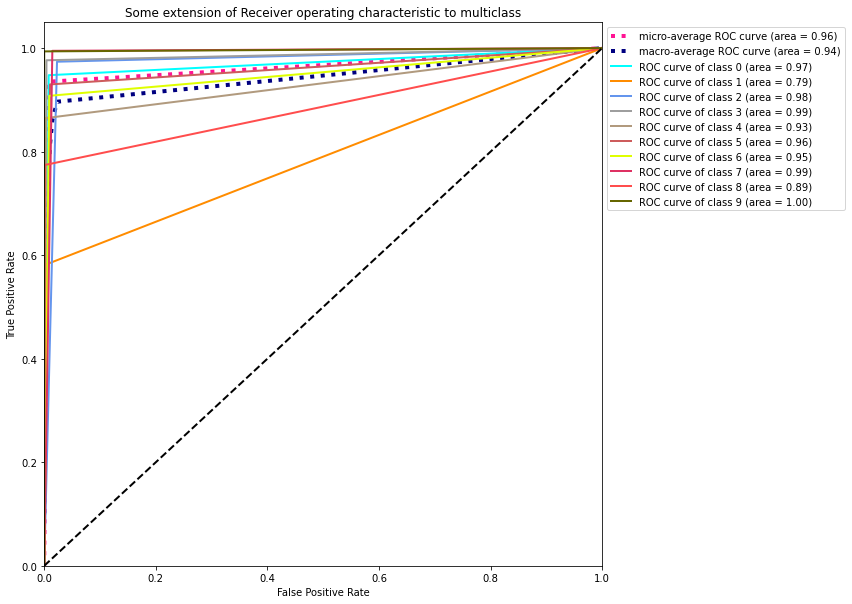

In [35]:
plot_roc_curve(y_test,y_pred2)

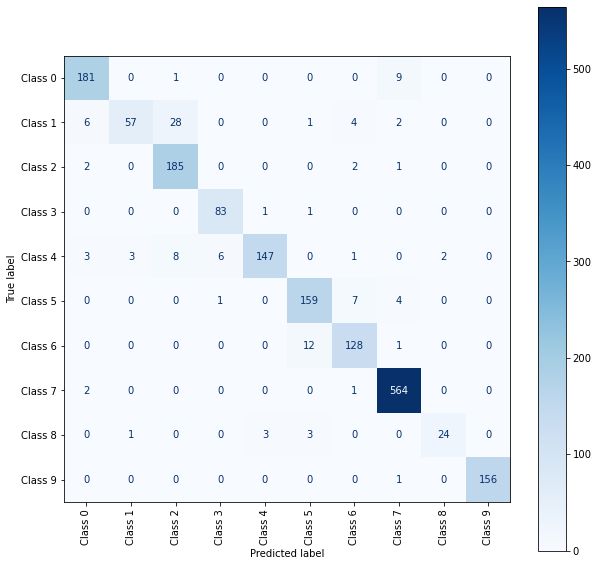

In [36]:
Confusion_Matrix(y_test1 , y_pred1)

In [44]:
X1=X_test.reshape(X_test.shape[0],128*128*3)

In [45]:
from sklearn.manifold import TSNE
tsne2 = TSNE(random_state = 42, n_components=3, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

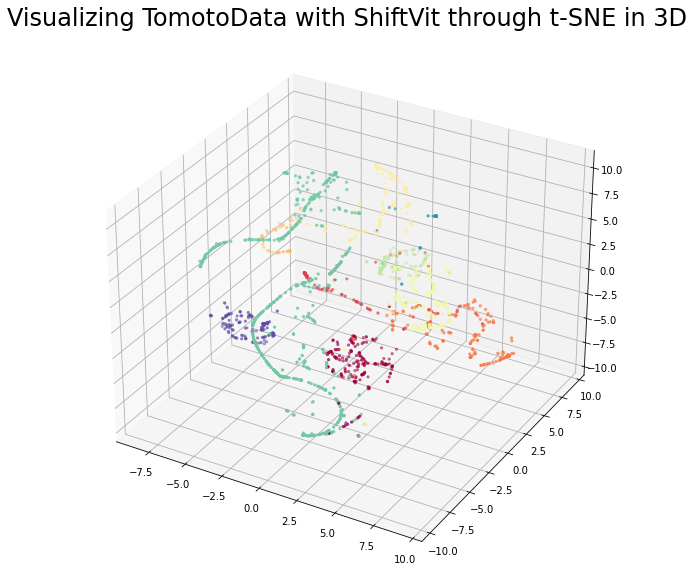

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne2[:, 0], tsne2[:, 1],tsne2[:,2], s=5, c=y_test1, cmap='Spectral')
plt.title('Visualizing TomotoData with ShiftVit through t-SNE in 3D', fontsize=24);
plt.show()


In [ ]:
model.save_weights('/kaggle/working/model.h5')